In [2]:
from pathlib import Path
from typing import Tuple, List
import pandas as pd

def read_timestamped_simplices(
    nverts_path: str | Path,
    simplices_path: str | Path,
    times_path: str | Path,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Read a timestamped simplex dataset (three integer-per-line files) and
    return:
      - simplices_df: one row per simplex with columns [sid, time, size, nodes]
      - incidence_df: one row per (sid, node) with columns [sid, node, time, size]
    """
    nverts_path     = Path(nverts_path)
    simplices_path  = Path(simplices_path)
    times_path      = Path(times_path)

    # --- Load as integer Series (robust to trailing spaces/newlines) ---
    nverts = pd.read_csv(nverts_path, header=None, names=["size"], dtype="Int64").iloc[:, 0]
    times  = pd.read_csv(times_path,  header=None, names=["time"], dtype="Int64").iloc[:, 0]
    nodes  = pd.read_csv(simplices_path, header=None, names=["node"], dtype="Int64").iloc[:, 0]

    # Basic integrity checks
    if nverts.isna().any() or times.isna().any() or nodes.isna().any():
        raise ValueError("Non-integer or missing values detected in one of the files.")
    if len(nverts) != len(times):
        raise ValueError(f"Length mismatch: nverts={len(nverts)} vs times={len(times)}")
    expected_nodes = int(nverts.sum())
    if len(nodes) != expected_nodes:
        raise ValueError(f"Nodes vector length ({len(nodes)}) != sum(nverts) ({expected_nodes}).")

    # --- Build simplex ids and slice nodes per simplex efficiently ---
    offsets = nverts.cumsum().shift(fill_value=0).astype(int)
    ends    = nverts.cumsum().astype(int)
    sid     = pd.RangeIndex(start=0, stop=len(nverts), step=1, name="sid")

    # Collect nodes per simplex
    nodes_per_simplex: List[List[int]] = [
        nodes.iloc[offsets[i]:ends[i]].astype(int).tolist() for i in sid
    ]

    simplices_df = pd.DataFrame({
        "sid": sid,
        "time": times.astype(int).values,
        "size": nverts.astype(int).values,
        "nodes": nodes_per_simplex,
    })

    incidence_df = (
        simplices_df[["sid", "time", "size", "nodes"]]
        .explode("nodes", ignore_index=True)
        .rename(columns={"nodes": "node"})
        .astype({"sid": int, "time": int, "size": int, "node": int})
        .sort_values(["sid"])
        .reset_index(drop=True)
    )

    return simplices_df, incidence_df


In [3]:

if __name__ == "__main__":
    # Example file stems; change "example" to your dataset prefix
    simplices_df, incidence_df = read_timestamped_simplices(
        "NDC-substances/NDC-substances-nverts.txt",
        "NDC-substances/NDC-substances-simplices.txt",
        "NDC-substances/NDC-substances-times.txt",
    )

    print(simplices_df.head())   # one row per simplex
    print(incidence_df.head())   # one row per (sid, node)
    # Optionally save:
    # simplices_df.to_csv("simplices_table.csv", index=False)
    # incidence_df.to_csv("incidence_table.csv", index=False)


   sid            time  size nodes
0    0  63474192000000     1   [1]
1    1  61521120000000     1   [2]
2    2  63551001600000     1   [3]
3    3  63551001600000     1   [3]
4    4  63594288000000     1   [4]
   sid            time  size  node
0    0  63474192000000     1     1
1    1  61521120000000     1     2
2    2  63551001600000     1     3
3    3  63551001600000     1     3
4    4  63594288000000     1     4


In [4]:
import pandas as pd
import numpy as np

OFFSET_MS = 62135596800000  # ms from 0001-01-01 to 1970-01-01

def ms_from_year1_to_datetime(s: pd.Series) -> pd.Series:
    """
    Convert milliseconds since 0001-01-01 (proleptic Gregorian) to pandas datetime (UTC).
    Works on an integer Series; safely handles NaNs.
    """
    s_num = pd.to_numeric(s, errors='coerce')           # -> float with NaNs
    mask = s_num.notna()
    out = pd.Series(pd.NaT, index=s.index, dtype='datetime64[ns, UTC]')
    out[mask] = pd.to_datetime((s_num[mask].astype('int64') - OFFSET_MS), unit='ms', utc=True)
    return out

# Apply to your table
simplices_df["datetime_utc"] = ms_from_year1_to_datetime(simplices_df["time"])
simplices_df["date"] = simplices_df["datetime_utc"].dt.date
incidence_df["datetime_utc"] = ms_from_year1_to_datetime(incidence_df["time"])
incidence_df["date"] = incidence_df["datetime_utc"].dt.date
simplices_df["day_index"] = (simplices_df["datetime_utc"].dt.floor('D') - simplices_df["datetime_utc"].dt.floor('D').min()).dt.days
incidence_df["day_index"] = (incidence_df["datetime_utc"].dt.floor('D') - incidence_df["datetime_utc"].dt.floor('D').min()).dt.days

In [5]:
simplices_df.head()

,sid,time,size,nodes,datetime_utc,date,day_index
0,0,63474192000000,1,[1],2012-06-02 00:00:00+00:00,2012-06-02,41059
1,1,61521120000000,1,[2],1950-07-13 00:00:00+00:00,1950-07-13,18454
2,2,63551001600000,1,[3],2014-11-08 00:00:00+00:00,2014-11-08,41948
3,3,63551001600000,1,[3],2014-11-08 00:00:00+00:00,2014-11-08,41948
4,4,63594288000000,1,[4],2016-03-23 00:00:00+00:00,2016-03-23,42449


In [6]:
incidence_df.head()

,sid,time,size,node,datetime_utc,date,day_index
0,0,63474192000000,1,1,2012-06-02 00:00:00+00:00,2012-06-02,41059
1,1,61521120000000,1,2,1950-07-13 00:00:00+00:00,1950-07-13,18454
2,2,63551001600000,1,3,2014-11-08 00:00:00+00:00,2014-11-08,41948
3,3,63551001600000,1,3,2014-11-08 00:00:00+00:00,2014-11-08,41948
4,4,63594288000000,1,4,2016-03-23 00:00:00+00:00,2016-03-23,42449


In [7]:
simplices_df = simplices_df.sort_values(by="day_index", ascending=True).reset_index(drop=True)
incidence_df = incidence_df.sort_values(by="day_index", ascending=True).reset_index(drop=True)

In [8]:
simplices_df.tail(10)

,sid,time,size,nodes,datetime_utc,date,day_index
112395,92753,63641548800000,1,[571],2017-09-21 00:00:00+00:00,2017-09-21,42996
112396,92752,63641548800000,1,[568],2017-09-21 00:00:00+00:00,2017-09-21,42996
112397,92795,63641548800000,1,[77],2017-09-21 00:00:00+00:00,2017-09-21,42996
112398,92796,63641548800000,1,[77],2017-09-21 00:00:00+00:00,2017-09-21,42996
112399,88934,63641548800000,1,[1865],2017-09-21 00:00:00+00:00,2017-09-21,42996
112400,71775,63641548800000,3,"[319, 1179, 1647]",2017-09-21 00:00:00+00:00,2017-09-21,42996
112401,108190,63641548800000,1,[161],2017-09-21 00:00:00+00:00,2017-09-21,42996
112402,108191,63641548800000,1,[370],2017-09-21 00:00:00+00:00,2017-09-21,42996
112403,68189,63641635200000,1,[277],2017-09-22 00:00:00+00:00,2017-09-22,42997
112404,68190,63641635200000,1,[277],2017-09-22 00:00:00+00:00,2017-09-22,42997


In [9]:
simplices_df.head(10)

,sid,time,size,nodes,datetime_utc,date,day_index
0,36939,59926694400000,1,[1837],1900-01-02 00:00:00+00:00,1900-01-02,0
1,23699,59926694400000,1,[752],1900-01-02 00:00:00+00:00,1900-01-02,0
2,59294,59926694400000,1,[1838],1900-01-02 00:00:00+00:00,1900-01-02,0
3,49788,59926694400000,1,[487],1900-01-02 00:00:00+00:00,1900-01-02,0
4,11779,59926694400000,2,"[1795, 1796]",1900-01-02 00:00:00+00:00,1900-01-02,0
5,21371,59926694400000,1,[752],1900-01-02 00:00:00+00:00,1900-01-02,0
6,94206,59927212800000,1,[790],1900-01-08 00:00:00+00:00,1900-01-08,6
7,16241,59958230400000,1,[776],1901-01-02 00:00:00+00:00,1901-01-02,365
8,105678,60099062400000,1,[4717],1905-06-20 00:00:00+00:00,1905-06-20,1995
9,105651,60156518400000,1,[842],1907-04-16 00:00:00+00:00,1907-04-16,2660


In [10]:
# rescale day_index to start from 0
min_day = simplices_df["day_index"].min()
simplices_df["day_index"] = simplices_df["day_index"] - min_day
incidence_df["day_index"] = incidence_df["day_index"] - min_day


In [11]:
# number of days
num_days = simplices_df["day_index"].max() + 1
num_days

np.int64(42998)

(array([8.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 8.0000e+00, 0.0000e+00, 3.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 5.6000e+01, 2.9000e+01,
        3.2100e+02, 6.0000e+00, 2.8000e+01, 2.5000e+01, 2.4000e+01,
        1.1400e+02, 4.1000e+01, 1.2100e+02, 9.0000e+01, 8.9800e+02,
        2.5200e+02, 1.5800e+02, 3.2850e+03, 2.8900e+02, 3.2600e+02,
        3.1900e+02, 6.0400e+02, 1.1330e+03, 1.1410e+03, 1.1910e+03,
        1.9060e+03, 2.9600e+03, 2.2740e+03, 3.7270e+03, 5.6190e+03,
        1.0437e+04, 2.2119e+04, 2.5319e+04, 2.7570e+04]),
 array([    0.        ,   977.20454545,  1954.40909091,  2931.61363636,
         3908.81818182,  4886.02272727,  5863.22727273,  6840.43181818,
         7817.63636364,  8794.84090909,  9772.04545455, 10749.25      ,
        11726.45454545, 12703.65909091, 13680.86363636, 14658.06818182,
        15635.27272727, 16612.47727273, 17589.68181818, 18566.88636364,
        19544.09090909, 20521.29545455

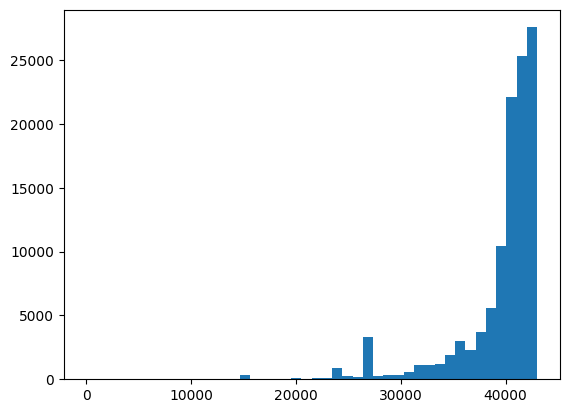

In [12]:
import matplotlib.pyplot as plt
plt.hist(simplices_df["day_index"], bins=44)

In [13]:
# let's filter the dataset from 1970
import datetime as dt
simplices_df = simplices_df[simplices_df["date"] >= dt.date(1970, 1, 1)]
incidence_df = incidence_df[incidence_df["date"] >= dt.date(1970, 1, 1)]



In [14]:
import pandas as pd

# If nodes are stored as lists (e.g. [870]), extract the single element
simplices_df["node"] = simplices_df["nodes"].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)

# Sort by date to ensure earliest first
df_sorted = simplices_df.sort_values("date")

# Keep only the earliest row per node
unique_simplices_df = df_sorted.drop_duplicates(subset="nodes", keep="first").reset_index(drop=True)


In [15]:
unique_simplices_df

,sid,time,size,nodes,datetime_utc,date,day_index,node
0,59271,62135683200000,1,[1838],1970-01-02 00:00:00+00:00,1970-01-02,25567,1838
1,62224,62135683200000,5,"[2384, 3852, 345, 1095, 3472]",1970-01-02 00:00:00+00:00,1970-01-02,25567,"[2384, 3852, 345, 1095, 3472]"
2,62193,62135683200000,5,"[3470, 3852, 345, 1095, 3472]",1970-01-02 00:00:00+00:00,1970-01-02,25567,"[3470, 3852, 345, 1095, 3472]"
3,59269,62135683200000,1,[1837],1970-01-02 00:00:00+00:00,1970-01-02,25567,1837
4,59270,62135683200000,1,[1840],1970-01-02 00:00:00+00:00,1970-01-02,25567,1840
...,...,...,...,...,...,...,...,...
9905,49957,63641030400000,1,[4150],2017-09-15 00:00:00+00:00,2017-09-15,42990,4150
9906,19580,63641030400000,3,"[1986, 1985, 359]",2017-09-15 00:00:00+00:00,2017-09-15,42990,"[1986, 1985, 359]"
9907,108646,63641116800000,2,"[1577, 1509]",2017-09-16 00:00:00+00:00,2017-09-16,42991,"[1577, 1509]"
9908,3393,63641289600000,1,[880],2017-09-18 00:00:00+00:00,2017-09-18,42993,880


C:\Users\leona\AppData\Local\Temp\ipykernel_39872\657654070.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  counts_monthly = unique_simplices_df.resample("M", on="date").size()


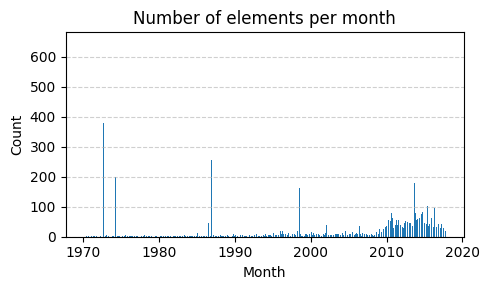

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'date' is datetime
unique_simplices_df["date"] = pd.to_datetime(unique_simplices_df["date"])

# Count number of elements per month
counts_monthly = unique_simplices_df.resample("M", on="date").size()

# Plot
plt.figure(figsize=(5, 3))
plt.bar(counts_monthly.index, counts_monthly.values, width=20)
plt.title("Number of elements per month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [17]:
import pandas as pd

# Ensure 'date' is datetime
unique_simplices_df["date"] = pd.to_datetime(unique_simplices_df["date"])

# Assign month (as Period for grouping)
unique_simplices_df["month"] = unique_simplices_df["date"].dt.to_period("M")

# Sort chronologically
unique_simplices_df = unique_simplices_df.sort_values("date")

# Initialize containers
seen_nodes = set()
new_nodes_per_month = {}

# Iterate month by month
for month, group in unique_simplices_df.groupby("month"):
    # Flatten all node lists in this month
    nodes_this_month = set().union(*group["nodes"])
    # Nodes that appear for the first time
    new_nodes = nodes_this_month - seen_nodes
    new_nodes_per_month[month] = len(new_nodes)
    # Update memory of seen nodes
    seen_nodes |= nodes_this_month

# Convert to pandas Series / DataFrame
new_nodes_df = pd.Series(new_nodes_per_month, name="new_nodes").sort_index()


In [18]:
unique_simplices_df

,sid,time,size,nodes,datetime_utc,date,day_index,node,month
0,59271,62135683200000,1,[1838],1970-01-02 00:00:00+00:00,1970-01-02,25567,1838,1970-01
1,62224,62135683200000,5,"[2384, 3852, 345, 1095, 3472]",1970-01-02 00:00:00+00:00,1970-01-02,25567,"[2384, 3852, 345, 1095, 3472]",1970-01
2,62193,62135683200000,5,"[3470, 3852, 345, 1095, 3472]",1970-01-02 00:00:00+00:00,1970-01-02,25567,"[3470, 3852, 345, 1095, 3472]",1970-01
3,59269,62135683200000,1,[1837],1970-01-02 00:00:00+00:00,1970-01-02,25567,1837,1970-01
4,59270,62135683200000,1,[1840],1970-01-02 00:00:00+00:00,1970-01-02,25567,1840,1970-01
...,...,...,...,...,...,...,...,...,...
9906,19580,63641030400000,3,"[1986, 1985, 359]",2017-09-15 00:00:00+00:00,2017-09-15,42990,"[1986, 1985, 359]",2017-09
9905,49957,63641030400000,1,[4150],2017-09-15 00:00:00+00:00,2017-09-15,42990,4150,2017-09
9907,108646,63641116800000,2,"[1577, 1509]",2017-09-16 00:00:00+00:00,2017-09-16,42991,"[1577, 1509]",2017-09
9908,3393,63641289600000,1,[880],2017-09-18 00:00:00+00:00,2017-09-18,42993,880,2017-09


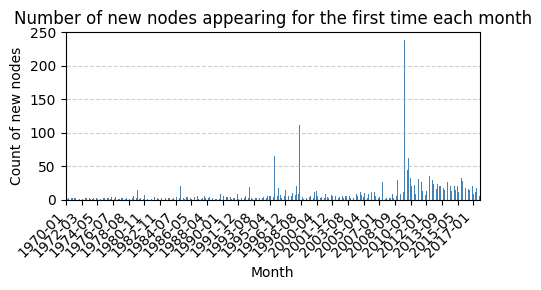

In [19]:
fig, ax = plt.subplots(figsize=(5, 3))
new_nodes_df.plot(kind="bar", color="steelblue", ax=ax)

ax.set_title("Number of new nodes appearing for the first time each month")
ax.set_xlabel("Month")
ax.set_ylabel("Count of new nodes")
ax.grid(axis="y", linestyle="--", alpha=0.6)
ax.set_ylim(0, 250)
# keep only every 3rd tick label
step = 20
ax.set_xticks(range(0, len(new_nodes_df), step))
ax.set_xticklabels(new_nodes_df.index[::step].astype(str), rotation=45, ha="right")

plt.tight_layout()
plt.show()


In [20]:

# Ensure 'date' is datetime
unique_simplices_df["date"] = pd.to_datetime(unique_simplices_df["date"])

# Extract year
unique_simplices_df["year"] = unique_simplices_df["date"].dt.year

# Build dictionary: {year -> set of frozensets}
simplices_by_year = (
    unique_simplices_df
    .groupby("year")["nodes"]
    .apply(lambda lst: {frozenset(nodes) for nodes in lst})
    .to_dict()
)


In [25]:
import pandas as pd

def ensure_frozensets(sby: dict[int, set]) -> dict[int, set[frozenset]]:
    """Ensure each year's collection is a set of frozensets."""
    out = {}
    for y, coll in sby.items():
        out[y] = {fs if isinstance(fs, frozenset) else frozenset(fs) for fs in coll}
    return out

def jaccard_distance(A: set, B: set) -> float:
    """Jaccard distance for sets of hashables (0 if both empty)."""
    if not A and not B:
        return 0.0
    inter = len(A & B)
    union = len(A | B)
    return 1.0 - (inter / union)

def jaccard_distance_matrix(simplices_by_year: dict[int, set]) -> pd.DataFrame:
    """
    Input:
      simplices_by_year: {year -> set of frozensets(nodes)}
    Output:
      DataFrame of Jaccard distances between years (symmetric, diag=0).
    """
    sby = ensure_frozensets(simplices_by_year)
    years = sorted(sby.keys())
    data = []
    for y1 in years:
        row = []
        for y2 in years:
            row.append(jaccard_distance(sby[y1], sby[y2]))
        data.append(row)
    return pd.DataFrame(data, index=years, columns=years)



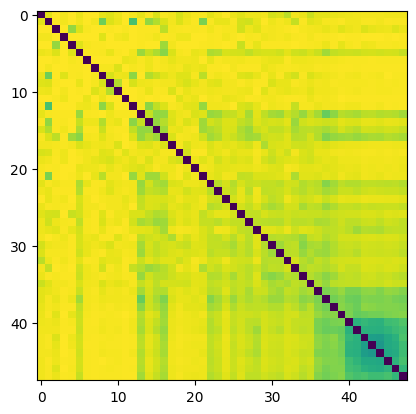

In [26]:
def jaccard_distance_matrix_nodes(simplices_by_year: dict[int, set]) -> pd.DataFrame:
    sby = ensure_frozensets(simplices_by_year)
    years = sorted(sby.keys())
    # Map year -> set of nodes
    nodes_by_year = {y: set().union(*sby[y]) if sby[y] else set() for y in years}
    data = []
    for y1 in years:
        row = []
        for y2 in years:
            row.append(jaccard_distance(nodes_by_year[y1], nodes_by_year[y2]))
        data.append(row)
    return pd.DataFrame(data, index=years, columns=years)

dist_mat_nodes = jaccard_distance_matrix_nodes(simplices_by_year)
plt.imshow(dist_mat_nodes, cmap='viridis', interpolation='nearest')

In [ ]:
# 0) Ensure proper dtypes
df = unique_simplices_df.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])
df["year"] = df["date"].dt.year

# 1) Long "incidence" table: (year, node) with one row per (simplex, node)
#    If nodes might be tuples/sets, convert to list first.
inc_long = (
    df.loc[:, ["year", "nodes"]]
      .explode("nodes", ignore_index=True)
      .rename(columns={"nodes": "node"})
)

# 2) Annual hyperdegree: how many simplices (of any size) each node participates in per year
annual_deg = (
    inc_long
    .groupby(["year", "node"])
    .size()
    .rename("hyperdeg")
    .reset_index()
)

# 3) Pivot to a Year × Node matrix; fill missing with 0
deg_year_node = (
    annual_deg
    .pivot(index="year", columns="node", values="hyperdeg")
    .fillna(0)
    .astype(int)
    .sort_index()
)

# 4) CUMULATIVE hyperdegree over years (row-wise cumulative sum)
cumdeg_year_node = deg_year_node.cumsum(axis=0)

# 5) Year of introduction for each node (first year with cumulative > 0)
intro_mask = cumdeg_year_node.gt(0)
intro_year = intro_mask.idxmax(axis=0)          # Series: node -> first True row label (year)
# If a node never appears (shouldn't happen), idxmax gives the first year; guard it:
intro_year[~intro_mask.any(axis=0)] = np.nan

# 6) Order columns (nodes) by year of introduction, then by node id (stable secondary)
ordered_nodes = (
    pd.Series(intro_year)
    .sort_values(kind="mergesort")     # stable sort by intro year
    .index
)

cumdeg_ordered = cumdeg_year_node.loc[:, ordered_nodes]

# 7) (Optional) Also keep the annual (non-cumulative) matrix ordered the same way
deg_ordered = deg_year_node.loc[:, ordered_nodes]

# -------- Outputs you asked for --------
# cumdeg_ordered : Year × Node matrix of cumulative hyperdegree (columns ordered by intro year)
# intro_year     : Series mapping node -> year of introduction

# 8) (Optional) Quick heatmap of cumulative hyperdegree



C:\Users\leona\AppData\Local\Temp\ipykernel_39872\1143506617.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(cumdeg_ordered.values), aspect="auto")


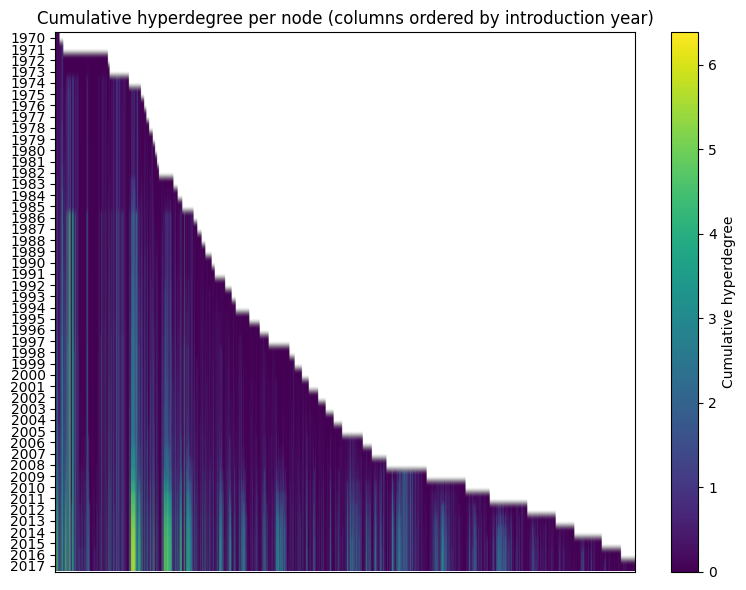

In [38]:
plt.figure(figsize=(8, 6))
plt.imshow(np.log(cumdeg_ordered.values), aspect="auto")
plt.colorbar(label="Cumulative hyperdegree")
plt.yticks(range(len(cumdeg_ordered.index)), cumdeg_ordered.index, rotation=0)
# less xticks, too many nodes
step = 100
# remove xticks, but call the ax nodes

plt.xticks([])

plt.title("Cumulative hyperdegree per node (columns ordered by introduction year)")
plt.tight_layout()
plt.show()

C:\Users\leona\AppData\Local\Temp\ipykernel_39872\2966739532.py:37: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(deg_ordered.values), aspect="auto")


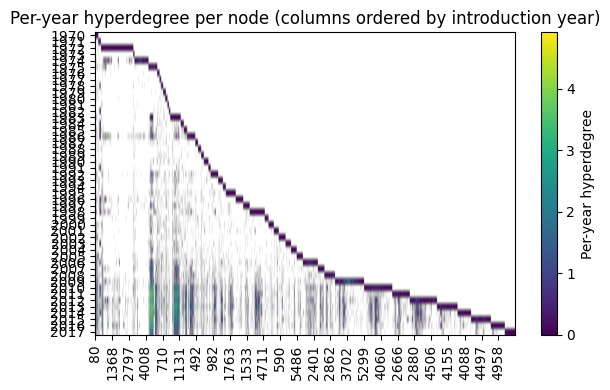

In [40]:

# --- starting from the objects built earlier ---
# df = unique_simplices_df with columns ['date','nodes', ...]
df = unique_simplices_df.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])
df["year"] = df["date"].dt.year

# 1) Long incidence table
inc_long = df.loc[:, ["year", "nodes"]].explode("nodes", ignore_index=True).rename(columns={"nodes":"node"})

# 2) Per-year hyperdegree (the “derivative”)
annual_deg = (
    inc_long.groupby(["year","node"]).size()
            .rename("hyperdeg").reset_index()
)

# 3) Pivot to Year×Node and fill zeros
deg_year_node = (
    annual_deg.pivot(index="year", columns="node", values="hyperdeg")
              .fillna(0).astype(int).sort_index()
)

# 4) Cumulative (used only to get intro years) + ordering
cumdeg_year_node = deg_year_node.cumsum(axis=0)
intro_year = cumdeg_year_node.gt(0).idxmax(axis=0)   # node -> first year seen
ordered_nodes = intro_year.sort_values(kind="mergesort").index

# 5) Reorder columns by introduction year
deg_ordered = deg_year_node.loc[:, ordered_nodes]

# 6) (optional) make years continuous (fill missing years with zeros)
years_full = np.arange(deg_ordered.index.min(), deg_ordered.index.max()+1)
deg_ordered = deg_ordered.reindex(years_full, fill_value=0)

# 7) Plot: “derivative” heatmap (per-year hyperdegree)
plt.figure(figsize=(6, 4))
plt.imshow(np.log(deg_ordered.values), aspect="auto")
plt.colorbar(label="Per-year hyperdegree")
plt.yticks(range(len(deg_ordered.index)), deg_ordered.index)
# show sparser x-ticks if many nodes
step = max(1, len(deg_ordered.columns)//25)
plt.xticks(range(0, len(deg_ordered.columns), step),
           deg_ordered.columns[::step], rotation=90)
plt.title("Per-year hyperdegree per node (columns ordered by introduction year)")
plt.tight_layout()
plt.show()
